In [33]:
import os
import math
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, ReLU, BatchNormalization, MaxPool2D, Concatenate
import cv2

### U-net Architecture

In [2]:
class UNet():
    """U-net neural network architecture"""

    def __init__(self, filter_num=64, batch_norm=True, pad="same"):
        self.filter_num = filter_num
        self.batch_norm = batch_norm
        self.pad = pad

    def conv_3x3(self, input, depth):
        """
        Convolves the input with a 3x3 kernel twice. with `filter_num` filters and 
        """
        # First convolution, apply batch-normalization if chosen, set activation function to ReLU
        conv1 = Conv2D(2**depth * self.filter_num, (3,3), padding=self.pad, kernel_initializer='he_normal')(input)
        if self.batch_norm:
            conv1 = BatchNormalization()(conv1)
        conv1 = ReLU()(conv1)
        
        # Second convolution, same procedure using the output of the first convolution
        conv2 = Conv2D(self.filter_num,(3,3),padding=self.pad)(conv1)
        if self.batch_norm:
            conv2 = BatchNormalization()(conv2)
        conv2 = ReLU()(conv2)

        return conv2
    
    def encoder(self, input, depth):
        """
        For a given layer at a certain depth, performs first the convolution operation and then a 2x2 max pool. 
        Returns the 2x2 max pool as well as a copy of the convolution to be used by the decoder
        depth=0 means top
        """
        # Convolve and then maxpool
        saved_layer = self.conv_3x3(input, depth)
        conv_maxpool = MaxPool2D(strides = (2,2))(saved_layer)

        return saved_layer, conv_maxpool
    
    def decoder(self, input, saved_layer, depth):
        "Decoder for the expansive path (right)"
        # 2x2 convolution (“up-convolution”), upsampling
        up_conv = Conv2DTranspose(2**depth * self.filter_num, (2,2), strides=2, padding="same")(input)
        
        # Concatenation with the correspondingly (cropped) feature map from the contracting path
        up_conv_cat = Concatenate()([up_conv, saved_layer])

        # 3x3 convolution
        result = self.conv_3x3(up_conv_cat, depth)
        
        return result
    
    def get_model(self, image_shape):
        """
        Creates the U-net architecture for a picture with a given input size
        """
        input = keras.Input(shape=image_shape)

        # Contracting path (left side) of the network architecture
        saved_layer0, left0 = self.encoder(input, 0)
        saved_layer1, left1 = self.encoder(left0, 1)
        saved_layer2, left2 = self.encoder(left1, 2)
        saved_layer3, left3 = self.encoder(left2, 3)

        # Convolution between contracting and expansive path
        middle = self.conv_3x3(left3, 4)

        # Expansive path (right side) of the network architecture
        right3 = self.decoder(middle, saved_layer3, 3)
        right2 = self.decoder(right3, saved_layer2, 2)
        right1 = self.decoder(right2, saved_layer1, 1)
        right0 = self.decoder(right1, saved_layer0, 0)

        # Convolute to 2d picture 
        output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(right0)

        model = keras.models.Model(input,output)
        return model


### Data model/generator

In [3]:
class SatImageSequence(keras.utils.Sequence):
    """
    From tensorflow documentation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
    """

    def __init__(self, x_set, y_set, batch_size=4):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size


    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([mpimg.imread(file_name) for file_name in batch_x]), np.array([mpimg.imread(file_name) for file_name in batch_y])

### Set up model

In [4]:
input_shape = (400, 400, 3)
u_net = UNet()
model = u_net.get_model(input_shape)
model.summary()

2021-11-26 19:41:11.947790: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 400, 400, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Set up data

In [5]:
def extract_data_unet(filename_img, filename_label):
    """ (ETH modified by ML_vikings) Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].

    Parameters
    ----------
    filename: string
        The name of the image file
    num_images: int
        The number of images that should be extracted

    Returns
    -------
    data: ndarray
        A numpy array containting the images
    """
    imgs = []
    labels = []
    for i in range(1, 100 + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename_img + imageid + ".png"
        label_filename = filename_label + imageid + ".png"
        if os.path.isfile(image_filename) and os.path.isfile(label_filename):
            #print('Loading ' + image_filename)
            #img = mpimg.imread(image_filename)
            imgs.append(image_filename)
            #lab = mpimg.imread(label_filename)
            labels.append(label_filename)
        else:
            print('File ' + image_filename + ' does not exist')
        
        for j in range(0):
            imageid = "satImage_%.3d" % i
            imageid += '_Aug%.2d' % j
            image_filename = filename_img + imageid + '.png'
            label_filename = filename_label + imageid + '.png'
            if os.path.isfile(image_filename) and os.path.isfile(label_filename):
                #print('Loading ' + image_filename)
                #img = mpimg.imread(image_filename)
                imgs.append(image_filename)
                #lab = mpimg.imread(label_filename)
                labels.append(label_filename)
            else:
                print('File ' + image_filename + ' does not exist')

    return imgs,labels

In [6]:
# Load data
data_dir = 'data/training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 
input_img_paths, target_img_paths = extract_data_unet(train_data_filename, train_labels_filename)

In [7]:
# Split our img paths into a training and a validation set
val_samples = 10
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatImageSequence(x_set=train_input_img_paths, y_set=train_target_img_paths)
val_gen = SatImageSequence(x_set=val_input_img_paths, y_set=val_target_img_paths)

### Train model

In [8]:
#model.compile(optimizer="rmsprop", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint("Unet_roadsegment.h5", save_best_only=True)]

epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2021-11-26 19:41:23.519275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
23/23 [==============================] - 349s 15s/step - loss: 0.5158 - accuracy: 0.6730 - val_loss: 11.9179 - val_accuracy: 0.0031
Epoch 2/20
23/23 [==============================] - 316s 14s/step - loss: 0.3899 - accuracy: 0.7372 - val_loss: 6.7228 - val_accuracy: 0.1006
Epoch 3/20
23/23 [==============================] - 299s 13s/step - loss: 0.3497 - accuracy: 0.7257 - val_loss: 6.1409 - val_accuracy: 0.2292
Epoch 4/20
23/23 [==============================] - 305s 13s/step - loss: 0.3193 - accuracy: 0.7271 - val_loss: 3.7056 - val_accuracy: 0.0299
Epoch 5/20
23/23 [==============================] - 311s 14s/step - loss: 0.2994 - accuracy: 0.7371 - val_loss: 2.9432 - val_accuracy: 0.7006
Epoch 6/20
23/23 [==============================] - 333s 15s/step - loss: 0.2696 - accuracy: 0.7516 - val_loss: 1.6540 - val_accuracy: 0.7053
Epoch 7/20
23/23 [==============================] - 320s 14s/step - loss: 0.2381 - accuracy: 0.7532 - val_loss: 0.7325 - val_accuracy: 0.6750
Epoch

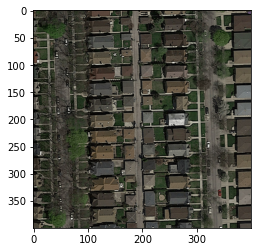

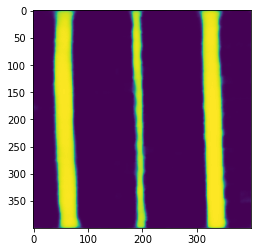

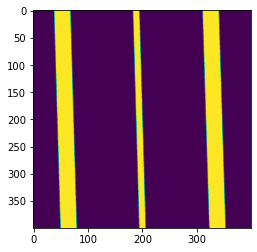

In [21]:
def predict(model,input_filename):
    prediction = model.predict(np.expand_dims(mpimg.imread(input_filename),0))
    return prediction[0]

k = 80
plt.figure()
plt.imshow(mpimg.imread(input_img_paths[k]))
plt.figure()
plt.imshow(predict(model,input_img_paths[k]))
plt.figure()
plt.imshow(mpimg.imread(target_img_paths[k]))

In [69]:
def patch_to_label(patch, foreground_threshold=0.25):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

# Predict for aicrowd test set
strings = []
submission_filename = "UnetPrediction1.csv"
for img_number in range(1,51):
    #Load image
    test_path = f"/Users/nikolaibeckjensen/Desktop/ml-project-2-vikings_ml/data/testing/test_{img_number}/test_{img_number}.png"
    im = mpimg.imread(test_path)

    # Rescale to fit input layer of network (400,400,3)
    im_downscaled = cv2.resize(im, dsize=(400, 400))

    # Predict on downscaled version. Then rescale back into original size
    prob = model.predict(np.expand_dims(im_downscaled,0))
    prediction = (prob > 0.5).astype(float).reshape(400,400)
    prediction = cv2.resize(prediction, dsize=(im.shape[0],im.shape[1]))

    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            strings.append("{:03d}_{}_{},{}".format(img_number, j, i, label))
    
with open(submission_filename, 'w') as f:
    f.write('id,prediction\n')
    f.writelines('{}\n'.format(s) for s in strings)



In [68]:
len(strings)

1444

In [64]:
1

1